In [0]:
!pip install pybullet

     |████████████████████████████████| 47.4MB 62.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/0b/cf/c0/94af8f5460286129b176b5c3814156c0cfb4d18a47d9cc4d6b
Successfully built pybullet


In [0]:
import datetime
import os
import numpy as np
import gym
from gym import wrappers
import pybullet_envs

In [0]:
class Hp():

    def __init__(self):
        self.nb_steps = 1000
        self.episode_length = 1000
        self.learning_rate = 0.02
        self.nb_directions = 16
        self.nb_best_directions = 16
        assert self.nb_best_directions <= self.nb_directions
        self.noise = 0.03
        self.seed = 1
        self.env_name = 'HumanoidBulletEnv-v0'
       # self.env_name = 'HalfCheetahBulletEnv-v0'
        #self.env_name = 'AntBulletEnv-v0'
        #self.env_name = 'InvertedPendulumBulletEnv-v0'


# Normalizing the states

class Normalizer():

    def __init__(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min=1e-2)

    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std


# Building the AI

class Policy():

    def __init__(self, input_size, output_size):
        self.theta = np.zeros((output_size, input_size))

    def evaluate(self, input, delta=None, direction=None):
        if direction is None:
            return self.theta.dot(input)
        elif direction == "positive":
            return (self.theta + hp.noise * delta).dot(input)
        else:
            return (self.theta - hp.noise * delta).dot(input)

    def sample_deltas(self):
        return [np.random.randn(*self.theta.shape) for _ in range(hp.nb_directions)]

    def update(self, rollouts, sigma_r):
        step = np.zeros(self.theta.shape)
        for r_pos, r_neg, d in rollouts:
            step += (r_pos - r_neg) * d
        self.theta += hp.learning_rate / (hp.nb_best_directions * sigma_r) * step


# Exploring the policy on one specific direction and over one episode

def explore(env, normalizer, policy, direction=None, delta=None):
    state = env.reset()
    done = False
    num_plays = 0.
    sum_rewards = 0
    while not done and num_plays < hp.episode_length:
        normalizer.observe(state)
        state = normalizer.normalize(state)
        action = policy.evaluate(state, delta, direction)
        state, reward, done, _ = env.step(action)
        reward = max(min(reward, 1), -1)
        sum_rewards += reward
        num_plays += 1
    return sum_rewards


# Training the AI
reward_for_plot=[]
def train(env, policy, normalizer, hp):
    for step in range(hp.nb_steps):

        # Initializing the perturbations deltas and the positive/negative rewards
        deltas = policy.sample_deltas()
        positive_rewards = [0] * hp.nb_directions
        negative_rewards = [0] * hp.nb_directions

        # Getting the positive rewards in the positive directions
        for k in range(hp.nb_directions):
            positive_rewards[k] = explore(env, normalizer, policy, direction="positive", delta=deltas[k])

        # Getting the negative rewards in the opposite directions
        for k in range(hp.nb_directions):
            negative_rewards[k] = explore(env, normalizer, policy, direction="negative", delta=deltas[k])

        # Gathering all the positive/negative rewards to compute the standard deviation of these rewards
        all_rewards = np.array(positive_rewards + negative_rewards)
        sigma_r = all_rewards.std()

        # Sorting the rollouts by the max(r_pos, r_neg) and selecting the best directions
        scores = {k: max(r_pos, r_neg) for k, (r_pos, r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
        order = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)[:hp.nb_best_directions]
        rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

        # Updating our policy
        policy.update(rollouts, sigma_r)

        # Printing the final reward of the policy after the update
        reward_evaluation = explore(env, normalizer, policy)
        print('Step:', step, 'Reward:', reward_evaluation)
        reward_for_plot.append(reward_evaluation)

In [0]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path


work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor1')

hp = Hp()
np.random.seed(hp.seed)
env = gym.make(hp.env_name)
env = wrappers.Monitor(env, monitor_dir, force=True)
nb_inputs = env.observation_space.shape[0]
nb_outputs = env.action_space.shape[0]
policy = Policy(nb_inputs, nb_outputs)
normalizer = Normalizer(nb_inputs)
train(env, policy, normalizer, hp)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Step: 0 Reward: 19
Step: 1 Reward: 24
Step: 2 Reward: 24
Step: 3 Reward: 24
Step: 4 Reward: 34.040263917302866
Step: 5 Reward: 37
Step: 6 Reward: 23
Step: 7 Reward: 27
Step: 8 Reward: 26
Step: 9 Reward: 24.94121274309235
Step: 10 Reward: 27
Step: 11 Reward: 30
Step: 12 Reward: 11.065235490146623
Step: 13 Reward: 29.79713851445225
Step: 14 Reward: 30
Step: 15 Reward: 26.736619192834933
Step: 16 Reward: 29.33615671489396
Step: 17 Reward: 29.469585559931303
Step: 18 Reward: 33
Step: 19 Reward: 25.055427235689432
Step: 20 Reward: 40.23619980056079
Step: 21 Reward: 40.973202832877206
Step: 22 Reward: 34.70190255309897
Step: 23 Reward: 24.81268178899544
Step: 24 Reward: 36.7381779715713
Step: 25 Reward: 27.19308714748172
Step: 26 Reward: 32.55418527682569
Step: 27 Reward: 19.696967760848903
Step: 28 Reward: 24.42888969682606
Step: 29 Reward: 52.9023577333483
Step: 30 Reward: 27.78303605751447
Step: 31 Reward: 26.22615864160815
Step: 32 Reward: 41.616479227560006
Step: 33 Reward: 35.445949020

In [0]:
len(reward_for_plot)

1000

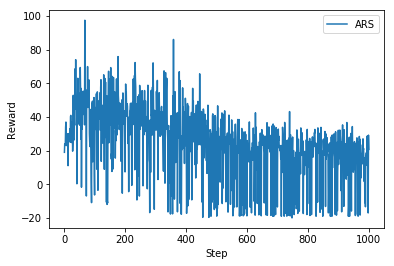

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(1,1001),reward_for_plot,label='ARS')
plt.ylabel('Reward')
plt.xlabel('Step')
ax.legend()
plt.show()